In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import argparse
import time
import cv2
import os

In [4]:
labelsPath = os.path.sep.join(['drive/MyDrive/Interview/darknet/data', "obj.names"])
labelsPath

'drive/MyDrive/Interview/darknet/data/obj.names'

In [5]:
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [10]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(['drive/MyDrive/Interview/yolov4', "yolov4_training_last.weights"])
configPath = os.path.sep.join(['drive/MyDrive/Interview/darknet/cfg', "yolov3_training.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [18]:
import os
os.listdir('drive/MyDrive/Interview/NN Models')

['dataset.csv',
 'final',
 'model_mask.h5',
 'model_mask.json',
 'model_helmet.h5',
 'model_helmet.json']

In [20]:
import tensorflow as tf
path = 'drive/MyDrive/Interview/NN Models/'
json_mask = open(os.path.join(path, 'model_mask.json'), 'r')
loaded_model_mask = json_mask.read()
json_mask.close()
model_mask = tf.keras.models.model_from_json(loaded_model_mask)
# load weights into new model
model_mask.load_weights(os.path.join(path, "model_mask.h5"))
print("Loaded model mask from disk")

Loaded model mask from disk


In [21]:
labels_mask = {0: 'invisible', 1: 'no', 2: 'wrong', 3: 'yes'}

In [23]:
path = 'drive/MyDrive/Interview/NN Models/'
json_helmet = open(os.path.join(path, 'model_helmet.json'), 'r')
loaded_model_helmet = json_helmet.read()
json_helmet.close()
model_helmet = tf.keras.models.model_from_json(loaded_model_helmet)
# load weights into new model
model_helmet.load_weights(os.path.join(path, "model_helmet.h5"))
print("Loaded helmet model from disk")

Loaded helmet model from disk


In [24]:
labels_helmet = {0: 'no', 1: 'yes'}

In [38]:
image_test = cv2.imread('drive/MyDrive/Interview/darknet/26.jpg')

In [49]:
# load our input image and grab its spatial dimensions

(H, W) = image_test.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image_test, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
layerOutputs = net.forward(ln)

In [50]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [51]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [57]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.6)

In [58]:
from keras.preprocessing import image
# x = image.img_to_array(resized)
if len(idxs) > 0:
  for i in idxs.flatten():
    try:
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])

      crop_image = image_test[y:y+h, x:x+w]
      dim = (64, 64)
      crop_image = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA)
      image_array = image.img_to_array(crop_image)
      image_array = np.expand_dims(image_array, axis=0)
      mask_array = model_mask.predict(image_array)
      helmet_array = model_helmet.predict(image_array)
      print(helmet_array, mask_array)
      mask = np.argmax(mask_array)
      if helmet_array[0][0] > 0.5:  
        helmet = 1
      else:
        helmet = 0
      color = color = (0, 0, 0)
      cv2.rectangle(image_test, (x, y), (x + w, y + h), color, 2)
      text = "mask:{} helmet:{}".format(labels_mask[mask], labels_helmet[helmet])
      cv2.putText(image_test, text, (x, y + h + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    except:
      pass

[[8.0110325e-08]] [[5.6214564e-12 5.1360425e-17 1.1551291e-35 1.0000000e+00]]
[[1.]] [[2.6451451e-06 1.4778462e-12 0.0000000e+00 9.9999738e-01]]
[[1.3268371e-24]] [[1.3135543e-28 1.0000000e+00 0.0000000e+00 3.5354712e-25]]
[[0.00032838]] [[1.0000000e+00 1.7618301e-22 0.0000000e+00 5.0631272e-08]]
[[1.]] [[2.7359373e-29 1.0000000e+00 0.0000000e+00 6.5774969e-10]]
[[1.]] [[7.2144645e-01 2.7840590e-01 6.9365888e-27 1.4765699e-04]]
[[1.]] [[1.82545841e-06 1.19344186e-04 2.64681471e-34 9.99878764e-01]]
[[3.8152415e-16]] [[1.0000000e+00 7.3377729e-28 0.0000000e+00 2.9180207e-19]]
[[1.3028919e-17]] [[9.9992681e-01 2.0523361e-29 0.0000000e+00 7.3198775e-05]]
[[1.]] [[9.9835122e-01 4.6909729e-05 6.2644338e-26 1.6019575e-03]]
[[2.5683083e-10]] [[1.0000000e+00 1.7721873e-18 4.6706185e-35 1.0475705e-09]]
[[0.5320541]] [[1.000000e+00 7.269005e-23 0.000000e+00 8.828922e-13]]
[[1.9969331e-05]] [[9.9999154e-01 6.0232878e-06 4.4903083e-12 2.3374375e-06]]
[[1.8272837e-08]] [[1.0000000e+00 1.1749667e-37 

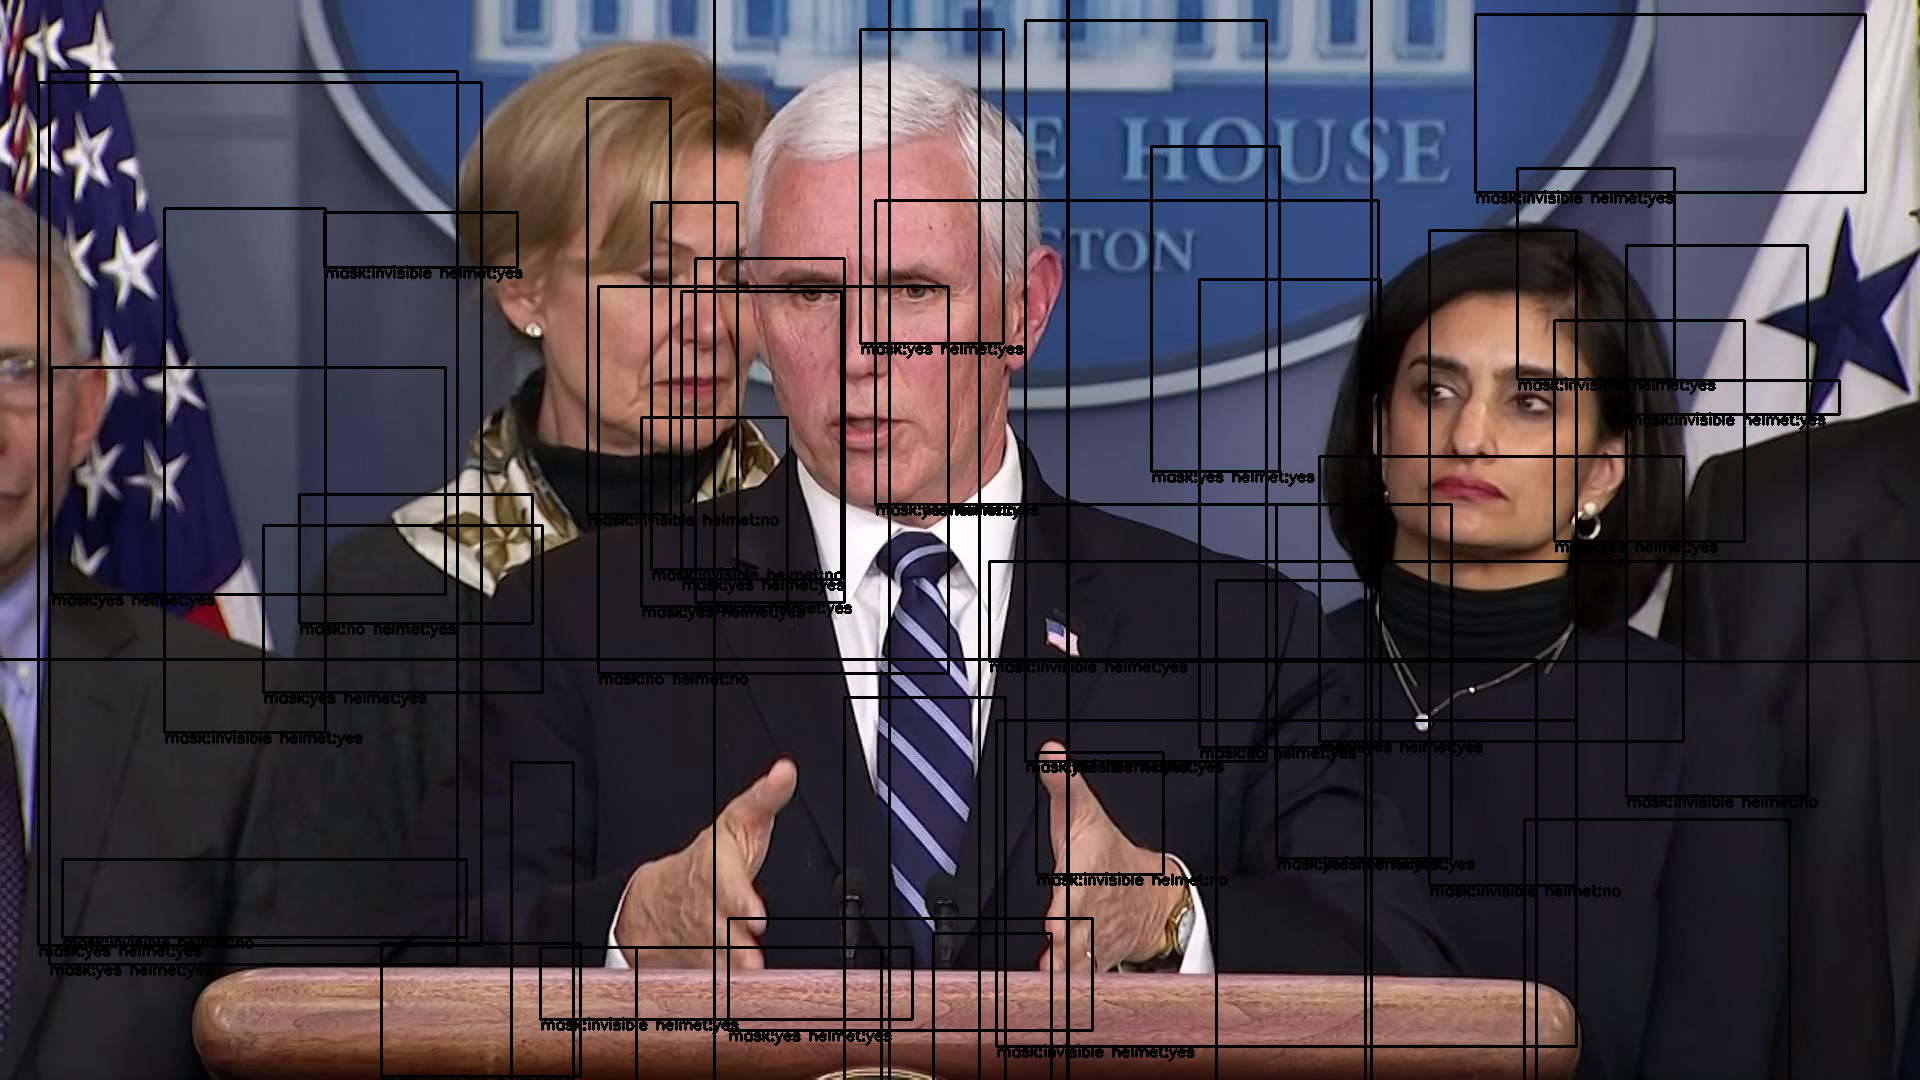

In [59]:
from google.colab.patches import cv2_imshow
cv2_imshow(image_test)